# dbt (data build tool)
[dbt](https://docs.getdbt.com/docs/introduction) does not extract or load data, but it’s state-of-the-art at transforming data that’s already available in a database — dbt does the T in ELT (Extract, Load, Transform) processes "inside a DWH".

---


## Set-up
### PostgreSQL
#### Start PostgreSQL database using the controlboard
Let's assume our raw data lives in a PostgreSQL database. Follow the instructions in the Notebook [Controlboard](controlboard.ipynb). 

#### Create a new table for dbt in PostgreSQL
<div class="alert alert-block alert-info">
<b>Note:</b> To run this code, make sure you select "Python 3 (ipkernel)" (Kernel -> Change Kernel)
</div>

Create a new database for this tutorial:

In [1]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy_utils import database_exists, create_database
from urllib import parse

In [4]:
# Name of your database - this database does NOT exist yet (create it below with `create_database()`)
database = 'tutorial'
username = 'dbuser'
password = 'rA4I2WYECsV4bqbw'

# Connection details according to docker-compose.yml - do not change this
dialect = 'postgresql'  # Could be almost any other DB technology
host = 'postgresql.myproject.svc.cluster.local'  # Name of the Kubernetes service
port = 5432

# URL-encode password for characters like %, ä, ...
password = parse.quote_plus(password)

url = f'{dialect}://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

In [5]:
if not database_exists(engine.url):
    create_database(engine.url)

print(f'Database "{database}" exists: {database_exists(engine.url)}')

Database "tutorial" exists: True


### Init dbt
We are using the Terminal within Jupyter since dbt expects some answers using the command prompt - this is impossible to implement using Jupyter cells here :-(. 

1. In Jupyter, hit the blue "+" sign at the top left and start a new Terminal
2. Create a new folder for dbt projects, then navigate to it:
```console
mkdir -p ~/work/dbt
cd ~/work/dbt
```
3. Tell the Terminal that you want to use the Python environment `dbt` instead of the standard `base` one (otherwise you'll get an error "bash: dbt: command not found"):
```console
(base) jovyan@...:~/$ conda activate dbt
(dbt) jovyan@...:~/$ 
```

4. Initialize dbt to create a new project called e.g. `tutorial` an entire new folder structure for your dbt project:
```console
dbt init tutorial
```
5. Answer dbt's questions e.g. like this:
    * Enter a name for your project (letters, digits, underscore): `tutorial`
    * Which database would you like to use? `1`
6. dbt saves connection infos by default to `~/.dbt/profiles.yml`. This is not useful since that file will be lost quickly if our Jupyter pod get deleted. Let's safe settings to e.g. `/data/dbt`:
```console
$ mkdir ~/data/dbt
```
7. Using Jupyter's file browser on the left, navigate to `/data/dbt`, right click into the empty large field below "Name" and create a new file called `profiles.yml`. Double click to open it.
8. Paste the following. Don't forget to set a password; the rest should be fine as-is.
```yaml
tutorial:
  outputs:

    dev:
      type: postgres
      threads: 1
      host: postgresql.myproject.svc.cluster.local
      port: 5432
      user: dbuser
      pass: rA4I2WYECsV4bqbw
      dbname: tutorial
      schema: public

  target: dev

```
9. Test your set-up using the terminal again:
```console
$ cd /home/jovyan/work/dbt/tutorial
$ dbt debug --profiles-dir /home/jovyan/data/dbt
```

## Set-up 

Make sure that you can view hidden Linux files: go to View -> "Show Hidden Files"
<div class="alert alert-block alert-info">
<b>Note:</b> Jupyter's "Show Hidden Files" is currently broken - you won't see all dbt files. Either edit any dbt files on your host computer or use the Jupyter command prompt.
</div>

## Set-up git
Todo

## Extract and load
Switch kernel from `dbt` to `Python 3 (ipkernel)`

In [ ]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy_utils import database_exists, create_database
from urllib import parse

import pandas as pd
import requests
import json

raw_data_url = 'https://github.com/openZH/covid_19/raw/master/fallzahlen_kanton_alter_geschlecht_csv/COVID19_Fallzahlen_Kanton_ZH_altersklassen_geschlecht.csv'
coingecko = 'https://api.coingecko.com/api/v3'
endpoint = '/coins/ethereum/market_chart'
params = {
    'vs_currency': 'CHF',
    'days': 90,
    'interval': 'hourly'
}

In [ ]:
# Name of your database - this database does NOT exist yet (create it below with `create_database()`)
database = 'tutorial'
username = 'dbuser'
password = '662VZUE5RJJG2puI'

# Connection details according to docker-compose.yml - do not change this
dialect = 'postgresql'  # Could be almost any other DB technology
host = 'postgresql.myproject.svc.cluster.local'  # Name of the Kubernetes service
port = 5432

# URL-encode password for characters like %, ä, ...
password = parse.quote_plus(password)

url = f'{dialect}://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

In [ ]:
if not database_exists(engine.url):
    create_database(engine.url)

print(f'Database "{database}" exists: {database_exists(engine.url)}')

In [ ]:
df = pd.read_csv(raw_data_url)
df

In [ ]:
r = requests.get(coingecko + endpoint, params=params)
r

In [ ]:
df = json.loads(r.text)
df = df['prices']
df = pd.DataFrame(df, columns=['time', 'value'])

In [ ]:
df['time'] = pd.to_datetime(df['time'] * 1000000)

In [ ]:
df

In [ ]:
df.to_sql(
    'raw_data',  # table name
    con=engine,
    if_exists='replace',
    index=False,  # In order to avoid writing DataFrame index as a column
)

In [ ]:
df2 = pd.read_sql('SELECT * FROM raw_data', con=engine)

In [ ]:
df2

## Energy Data
Have a look at the [API documentation for details](https://www.eia.gov/opendata/documentation.php) if you're interested. 

In [264]:
! pip install python-dotenv

In [280]:
import requests
import json
import pandas as pd
from pandas_profiling import ProfileReport
from pprint import pprint
import pendulum
import seaborn as sns

### API key and correct key handling
Register here to get an API key: https://www.eia.gov/opendata/register.php, takes 30 seconds. Create a new file `environment.env` in the same directory where this Notebook lies with the following content. Note that **no \*.env file is checked into GitHub** - you're responsible for backing these files up. 
```console
# API key for https://api.eia.gov
API_EIA_GOV_KEY=<enter your API key here>
```

Load the secret like this:

In [282]:
from dotenv import load_dotenv
load_dotenv('environment.env', override=True)  # take environment variables from environment.env

import os
api_key = os.getenv('API_EIA_GOV_KEY')

### Logging / informing the Jupyter Notebook user
We want to later put any functions here in Python modules and use Airflow. Instead of simply using `print()` in Jupyter Notebooks to get e.g. info on the current download status of data, let's use Python `logging`.

In [225]:
import logging

# Render INFO messages visible in a Jupyter Notebook
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### Functions
The API always needs an api key, a path and optional parameters. It returns JSON answers. Let's define a function that simplifies that and returns a Python dictionary.

In [220]:
def eia_api(api_key, path, params=None):
    """
    Hit the API of https://api.eia.gov at endpoint path (str)
    and optional URL parameters params (dict), e.g.
        api_key = '92nfLKfek3751lFLjfel34873'
        path = '/v2/electricity/rto'
        params = {'frequency': 'hourly', 'data[0]': 'value'}

    Returns result as dict; will remove the API key in the
    answer!
    Raises requests.exceptions.HTTPError if we get an HTTP
    status code of >=400
    """
    url = 'https://api.eia.gov'
    params = params or dict()
    params['api_key'] = api_key
    data = requests.get(url + path, params=params)
    data.raise_for_status()
    answer = json.loads(data.text)
    # Sanitize the return - get rid of the API key!
    try:
        del answer['request']['params']['api_key']
    except KeyError:
        pass
    return answer

Once the API actually returns data, it will do that in batches of ~5'000 entries only and JSON encoded. Let's define a function that returns a Pandas dataframe for that. Since the download could take forever, sprinkle `logging.info()` log entries to tell the user that something is happening. 

In [208]:
def eia_api_data(api_key, path, params=None):
    """
    Hit the API of https://api.eia.gov at endpoint path (str)
    and optional URL parameters params (dict), e.g.
        api_key = '92nfLKfek3751lFLjfel34873'
        path = '/v2/electricity/rto/data'
        params = {'frequency': 'hourly', 'data[0]': 'value'}
    Your path should probably end in `/data`!

    Returns result as dataframe
    Raises requests.exceptions.HTTPError if we get an HTTP
    status code of >=400
    Raises KeyError if you hit the wrong API endpoint
    """
    logging.info('Start data download')
    params = params or dict()
    data = eia_api(api_key, path, params)
    df = pd.DataFrame.from_dict(data['response']['data'])
    while data['response']['total'] > len(df):
        logging.info(f'Grabbing entries >{len(df)} of {data["response"]["total"]} entries total')
        params['offset'] = len(df)
        data = eia_api(api_key, path, params=params)
        df = pd.concat([df, pd.DataFrame.from_dict(data['response']['data'])])
    df.reset_index(drop=True, inplace=True)
    logging.info('Finished data download')
    return df

### Play with the API
Let's get more info on the API by hitting a couple of endpoints. The API returns JSON answers. Our function `eia_api()` turns JSON answers to Python dictionaries. Use `pprint()` to render the convoluted answers readable. 

In [ ]:
path = '/v2/electricity/rto'
pprint(eia_api(api_key, path))

In [ ]:
path = '/v2/electricity/rto/fuel-type-data'
pprint(eia_api(api_key, path))

In [ ]:
path = '/v2/electricity/rto/region-data'
pprint(eia_api(api_key, path))

### Get the data
We will use the endpiont `/v2/electricity/rto/region-data`, seems the most interesting one. 
<div class="alert alert-block alert-info">
<b>Caution:</b> Manually adjust the `start` here to only 5-7 days prior to today's date. Otherwise you'll wait forever. 
</div>

In [227]:
path = '/v2/electricity/rto/region-data/data'
params = {
    "frequency": "hourly",
    "data[0]": "value",
    "facets": {},
    "start": "2022-09-02T00",
    # "stop": "2022-09-02T00"
}
region_data = eia_api_data(api_key, path, params=params)
region_data

INFO:root:Start data download
INFO:root:Grabbing entries >5000 of 32060 entries total
INFO:root:Grabbing entries >10000 of 32060 entries total
INFO:root:Grabbing entries >15000 of 32060 entries total
INFO:root:Grabbing entries >20000 of 32060 entries total
INFO:root:Grabbing entries >25000 of 32060 entries total
INFO:root:Grabbing entries >30000 of 32060 entries total
INFO:root:Finished data download


,period,respondent,respondent-name,type,type-name,value,value-units
0,2022-09-02T01,SCL,Seattle City Light,DF,Day-ahead demand forecast,1119.0,megawatthours
1,2022-09-02T04,SW,Southwest,DF,Day-ahead demand forecast,12875.0,megawatthours
2,2022-09-02T02,SPA,Southwestern Power Administration,DF,Day-ahead demand forecast,80.0,megawatthours
3,2022-09-02T00,MISO,"Midcontinent Independent System Operator, Inc.",DF,Day-ahead demand forecast,100524.0,megawatthours
4,2022-09-02T04,TEN,Tennessee,DF,Day-ahead demand forecast,19448.0,megawatthours
...,...,...,...,...,...,...,...
32055,2022-09-04T03,CAR,Carolinas,NG,Net generation,27351.0,megawatthours
32056,2022-09-04T02,DOPD,PUD No. 1 of Douglas County,NG,Net generation,167.0,megawatthours
32057,2022-09-03T08,EPE,El Paso Electric Company,TI,Total interchange,-382.0,megawatthours
32058,2022-09-03T13,HGMA,"New Harquahala Generating Company, LLC",NG,Net generation,956.0,megawatthours


To get a lazy first look at the API's answers, `pandas_profiling.ProfileReport()` is useful for that:

In [ ]:
ProfileReport(region_data)

The field `period` is still of type string, convert it to a sensible timestamp:

In [ ]:
region_data['period'].apply(pendulum.parse, inplace=True)

Let's plot all values for a certain respondent

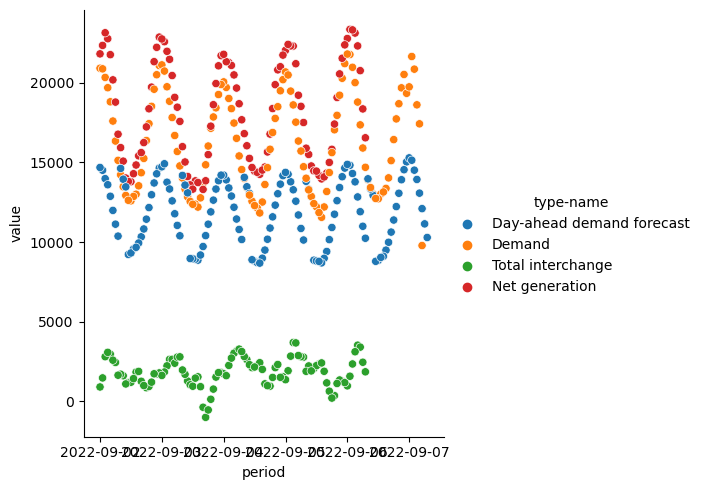

In [260]:
respondent = 'SW'

sns.relplot(data=region_data[region_data['respondent'] == respondent].dropna(), x='period', y='value', hue='type-name')